## Project: **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images    
`cv2.cvtColor()` to grayscale or change color    
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=18):
    """
    This function draws `lines` with `color` and `thickness`.    
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



#### Pipeline Initiate Data

In [3]:
kernel_size = 3
low_threshold = 64 # Define our parameters for Canny and apply
high_threshold = 192 # Define our parameters for Canny and apply


##### Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 32     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 1 #minimum number of pixels making up a line
max_line_gap = 200    # maximum gap in pixels between connectable line segments

#### Building The Image & Video Processing Pipeline function

In [4]:
def build_pipeline(image):
    h, w, _ = image.shape
    vertices = np.array([[w*0.125, h], [w*0.475, h*0.59], [w*0.52, h*0.59], [w*0.95, h]], dtype=np.int32)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, low_threshold, high_threshold)
    roi = region_of_interest(edges, [vertices])
    roi2 = region_of_interest(gray, [vertices])
    lines = hough_lines(roi2, rho, theta, threshold, min_line_len, max_line_gap)
    
    #Scanner Checker
    if(scanner==True):     
        image = region_of_interest(image, [vertices]) #scanner shape
        scanner_edges = canny(image, low_threshold, high_threshold)
        scanner_lines = hough_lines(scanner_edges, rho, theta, threshold, min_line_len, max_line_gap)
        
        
    result = weighted_img(image, lines, 0.9, 0.9)
    return result

## Test on Videos
We can test our solution on provided videos:   
`solidWhiteRight.mp4`   
`solidYellowLeft.mp4`    
`challenge.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML, display

#### Video Pipeline Generator & Video Loader Function

In [6]:
def video_generator(input,output,filter):
    clip = VideoFileClip(input)
    white_clip = clip.fl_image(filter) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)
    

def video_loader(header_text,ori_video,video,scanner_shape):
    display(HTML('<h2 style="text-align:center;">' + header_text + '</h2>' +
                 '<video width="320" height="180" controls><source src="' + ori_video + '"></video>' +
                 '<video width="320" height="180" controls><source src="' + video + '"></video>' +
                 '<video width="320" height="180" controls><source src="' + scanner_shape + '"></video>'))

#### Video Data

In [7]:
video_data = [['White Challenge','solidWhiteRight.mp4','white.mp4','whiteshape.mp4'],
             ['Yellow Challenge','solidYellowLeft.mp4','yellow.mp4','yellowshape.mp4'],
             ['Extra Challenge','challenge.mp4','extra.mp4','extrashape.mp4']] # Optional Challenge

#Test Code , will remove soon
scanner = False
video_generator(video_data[2][1],video_data[2][2],build_pipeline)

#### Generate Pipeline on Video And Display All Video

In [9]:
for i in video_data:    
    scanner = False
    video_generator(i[1],i[2],build_pipeline)
    scanner = True
    video_generator(i[1],i[3],build_pipeline)
    video_loader(i[0],i[1],i[2],i[3])

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 92.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.06 s, sys: 188 ms, total: 3.25 s
Wall time: 2.66 s
[MoviePy] >>>> Building video whiteshape.mp4
[MoviePy] Writing video whiteshape.mp4


100%|█████████▉| 221/222 [00:03<00:00, 68.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: whiteshape.mp4 

CPU times: user 5.15 s, sys: 388 ms, total: 5.54 s
Wall time: 3.34 s


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:08<00:00, 84.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.2 s, sys: 464 ms, total: 10.6 s
Wall time: 8.37 s
[MoviePy] >>>> Building video yellowshape.mp4
[MoviePy] Writing video yellowshape.mp4


100%|█████████▉| 681/682 [00:10<00:00, 66.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellowshape.mp4 

CPU times: user 16.5 s, sys: 1.05 s, total: 17.6 s
Wall time: 10.4 s


[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:05<00:00, 49.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.26 s, sys: 316 ms, total: 6.58 s
Wall time: 5.6 s
[MoviePy] >>>> Building video extrashape.mp4
[MoviePy] Writing video extrashape.mp4


100%|██████████| 251/251 [00:06<00:00, 39.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extrashape.mp4 

CPU times: user 11.1 s, sys: 328 ms, total: 11.4 s
Wall time: 6.58 s


## Test Images
**Test on images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg']

#### Process Of Building Pipeline In Image

In [11]:
def showimg(subplace, title, _img):
    plt.subplot(*subplace)
    plt.title(title)
    if len(_img.shape) == 3:
        plt.imshow(_img)
    else:
        plt.imshow(_img, cmap='gray')
        
def pipeline_process(image):
    h, w, _ = image.shape
    vertices = np.array([[w*0.125, h], [w*0.475, h*0.59], [w*0.52, h*0.59], [w*0.95, h]], dtype=np.int32)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, low_threshold, high_threshold)
    roi = region_of_interest(edges, [vertices])
    roi2 = region_of_interest(gray, [vertices])
    lines = hough_lines(roi2, rho, theta, 50, min_line_len, max_line_gap)
    result = weighted_img(image, lines, 0.9, 0.9)

    #Scanner checker
    scanner_shape = region_of_interest(image, [vertices])
    scanner_edges = canny(scanner_shape, low_threshold, high_threshold)
    scanner_lines = hough_lines(scanner_edges, rho, theta, threshold, min_line_len, max_line_gap)
    scanner = weighted_img(scanner_shape, lines, 0.9, 0.9)

    plt.figure(figsize=[20, 13])    
    for i, img in enumerate(['scanner_shape', 'scanner_edges', 'scanner_lines', 'scanner']):
        showimg((2, 2, i+1), img, eval(img))
        
    plt.figure(figsize=[20, 13])
    for i, img in enumerate(['image', 'yellow', 'white', 'gray', 'edges', 'roi', 'roi2', 'lines','result']):
        showimg((3, 3, i+1), img, eval(img))


#### Generate Pipeline On Images And Display All The Process

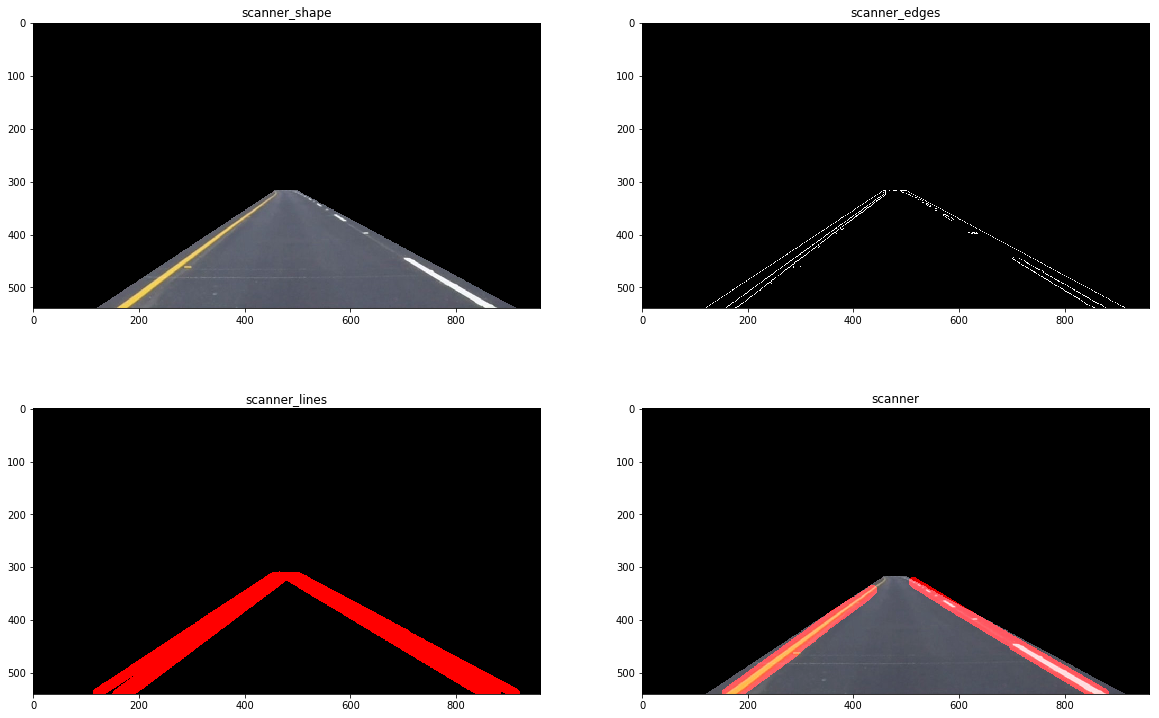

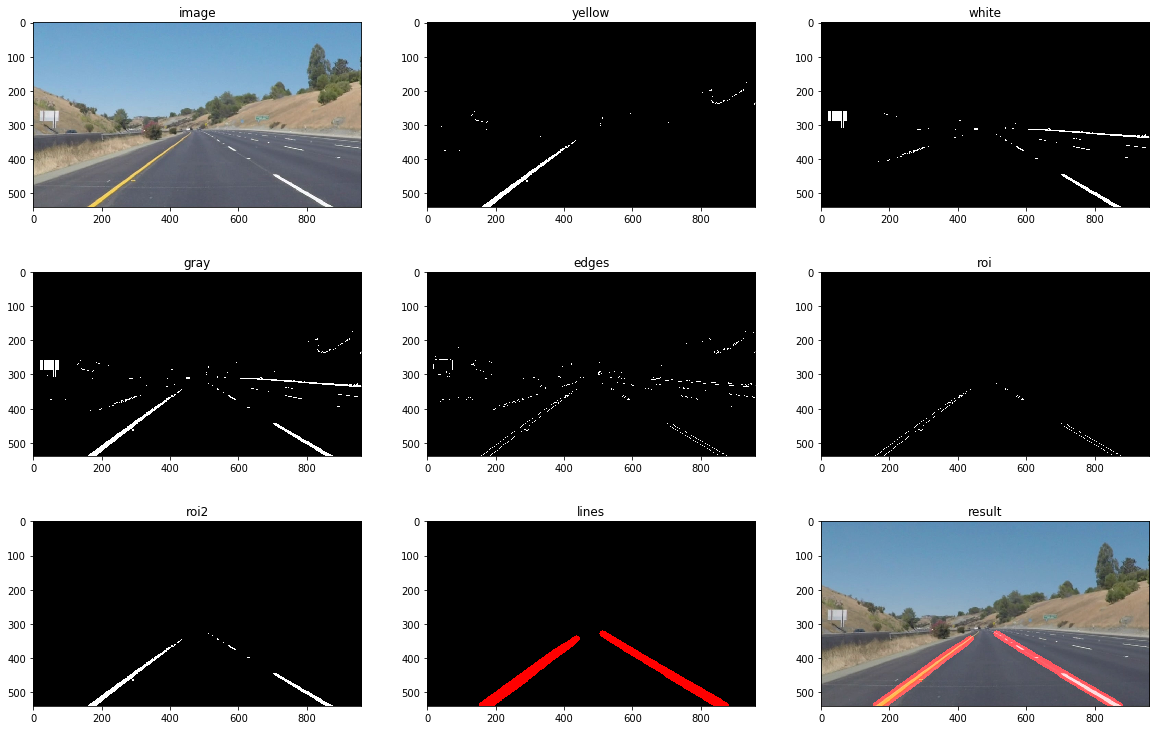

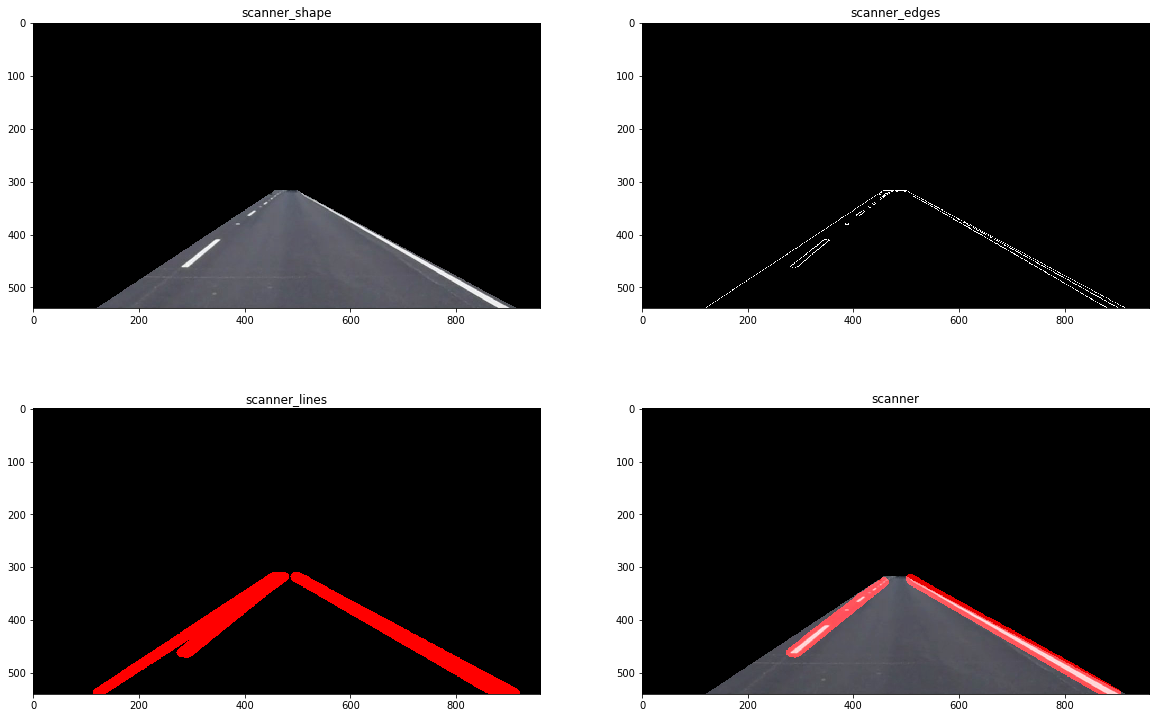

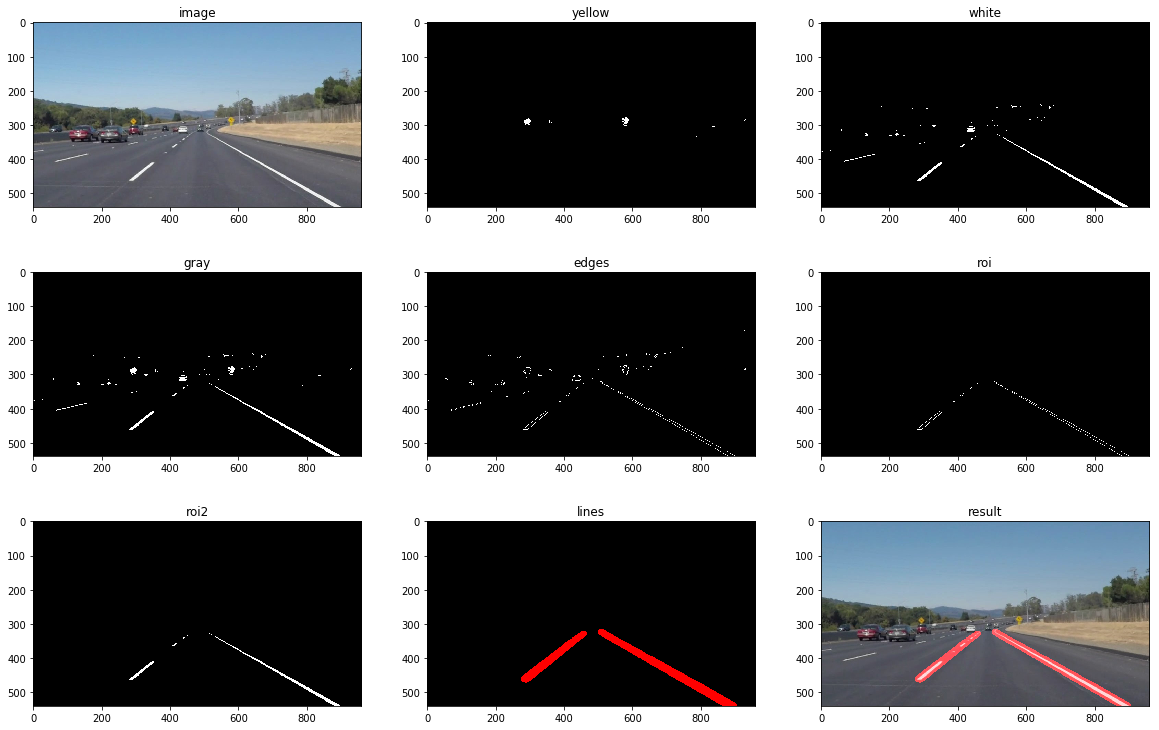

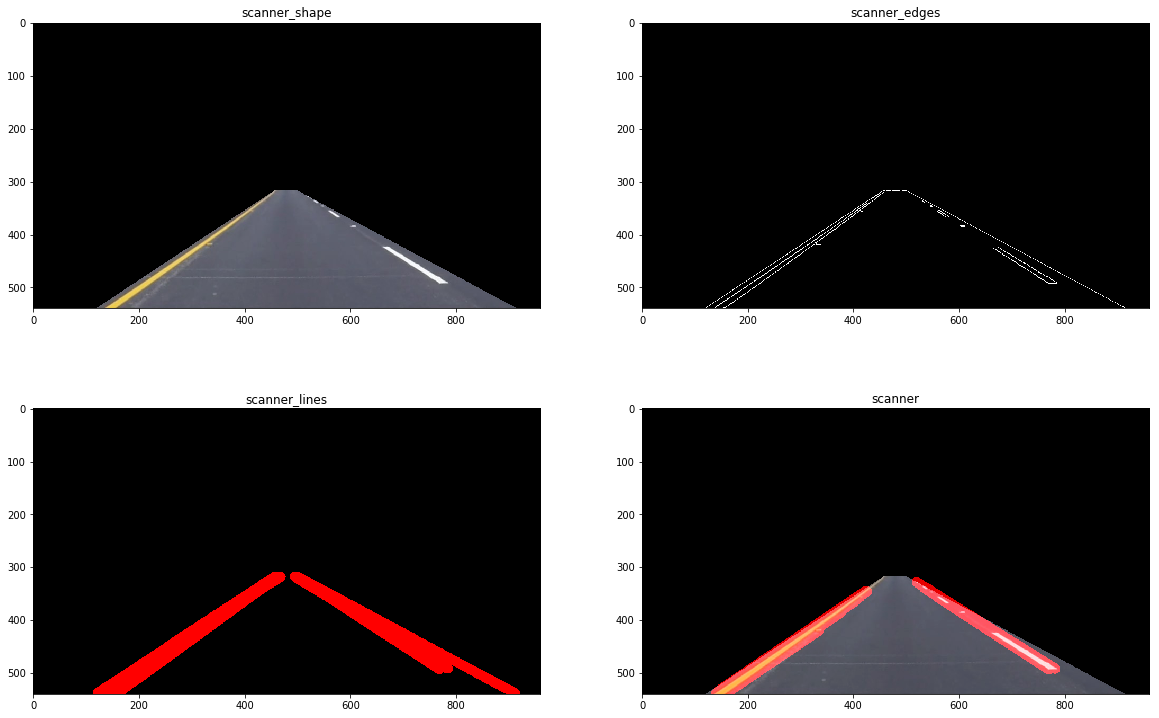

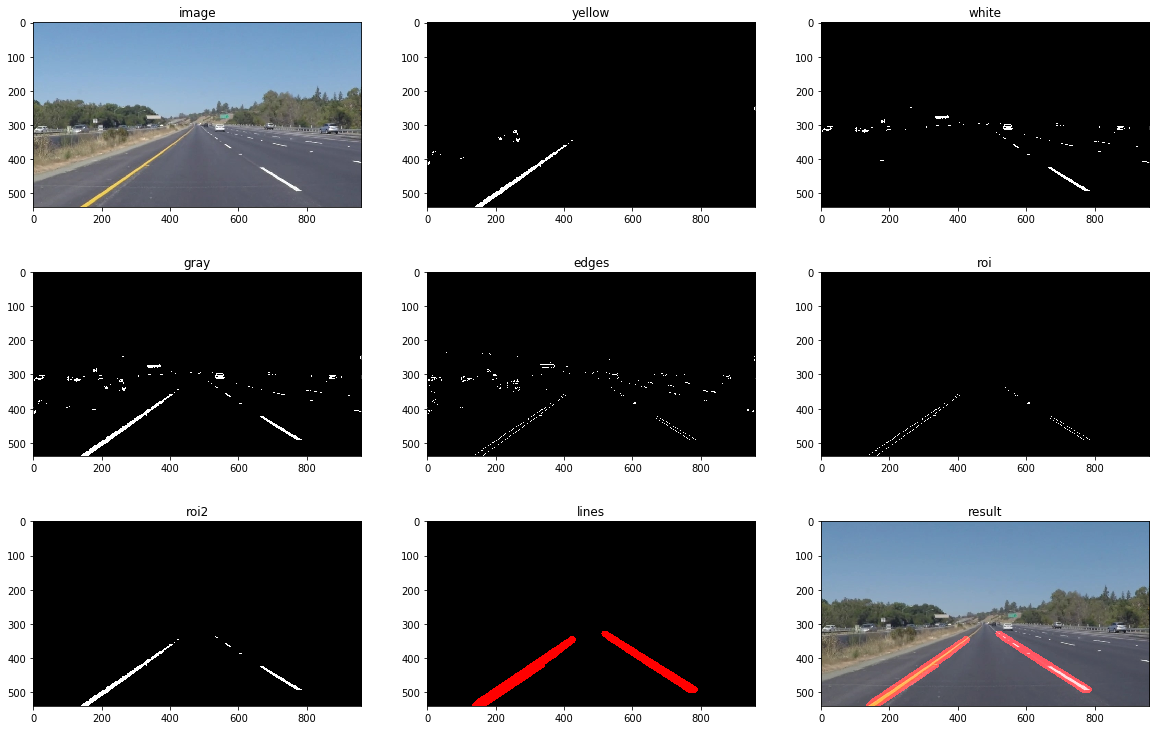

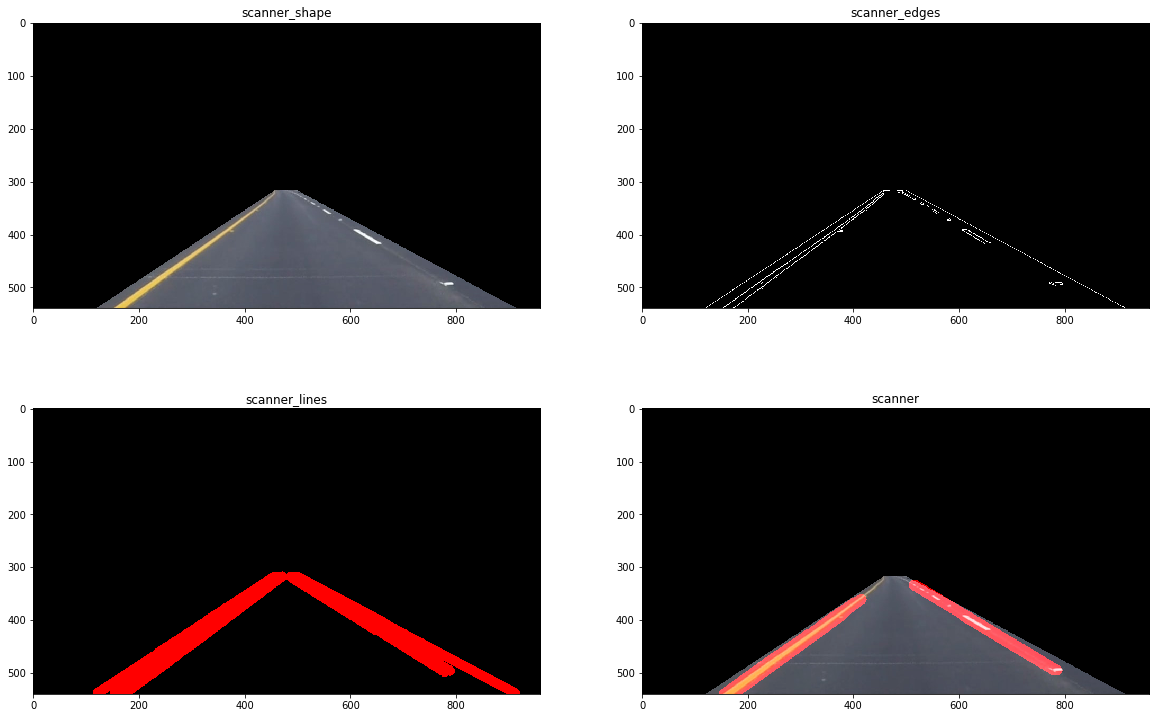

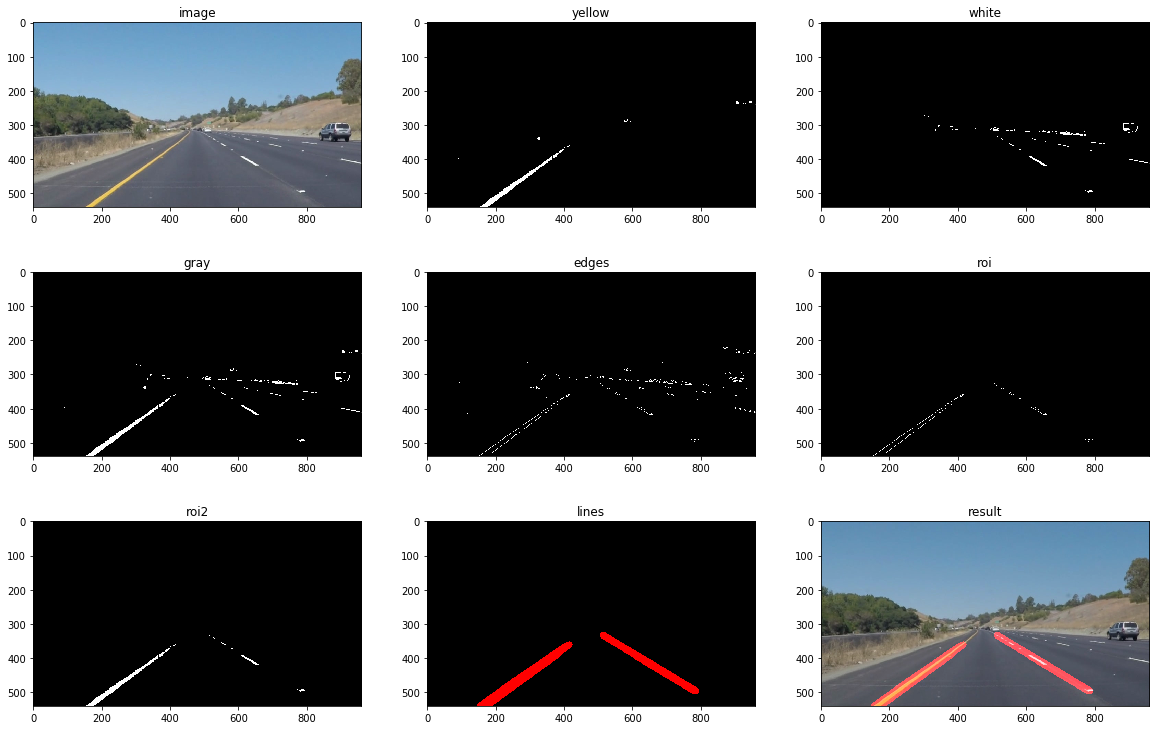

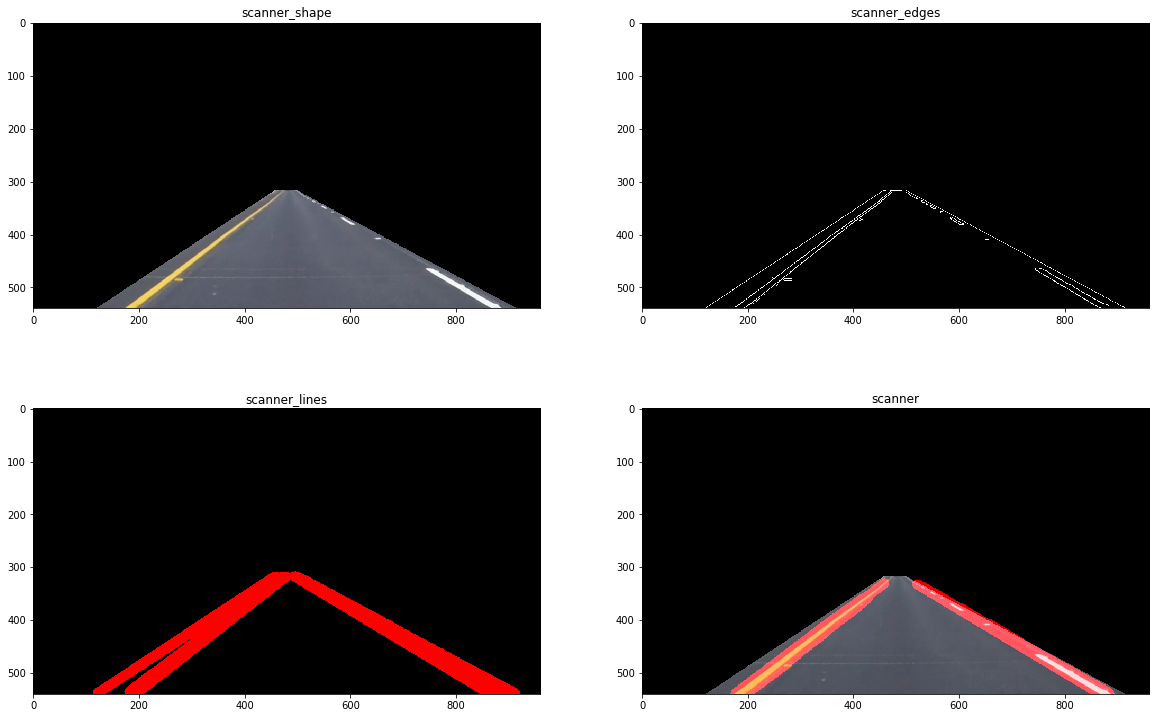

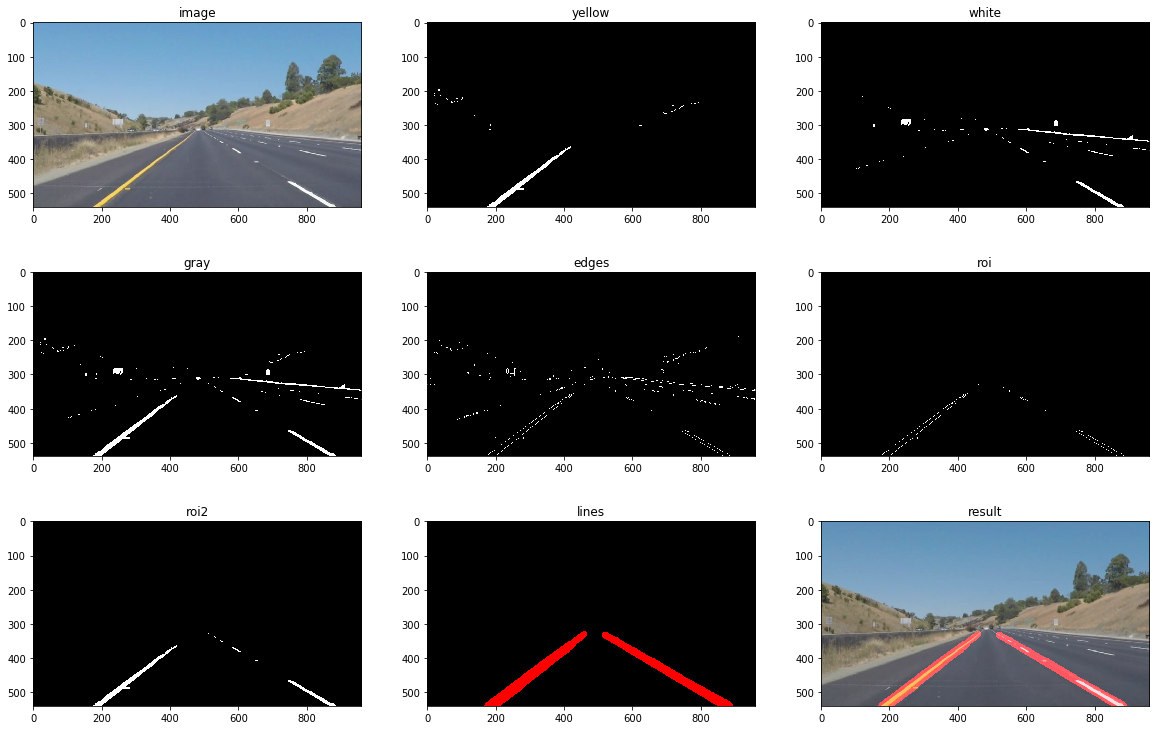

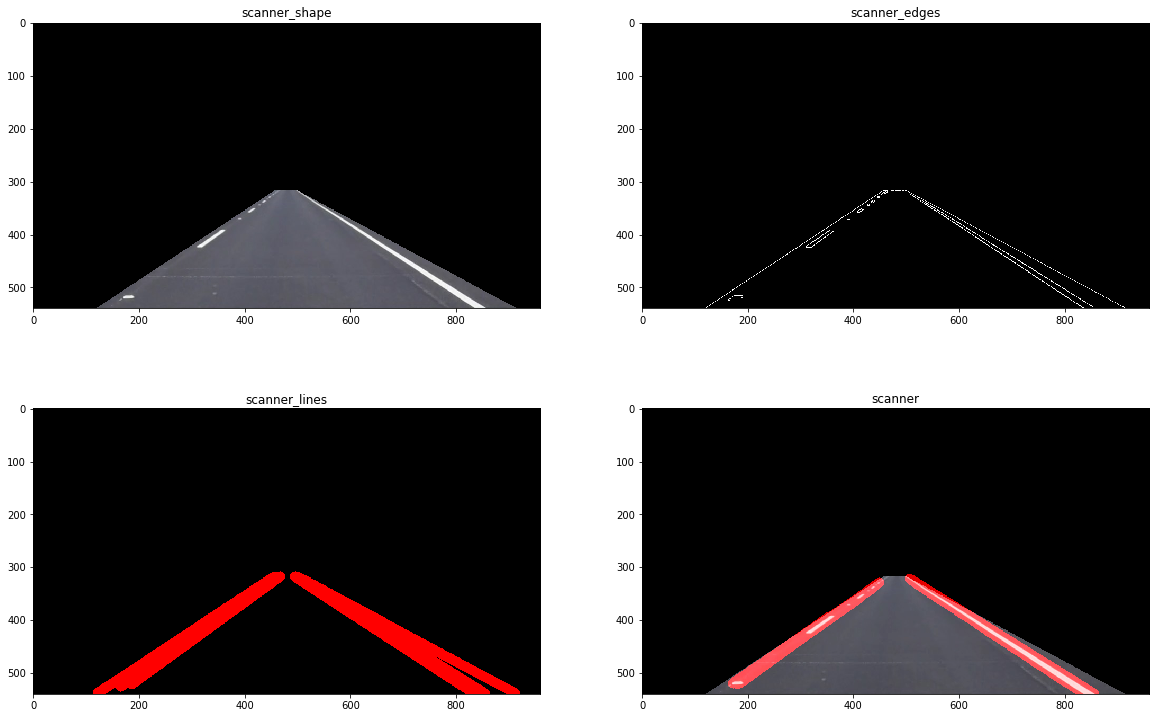

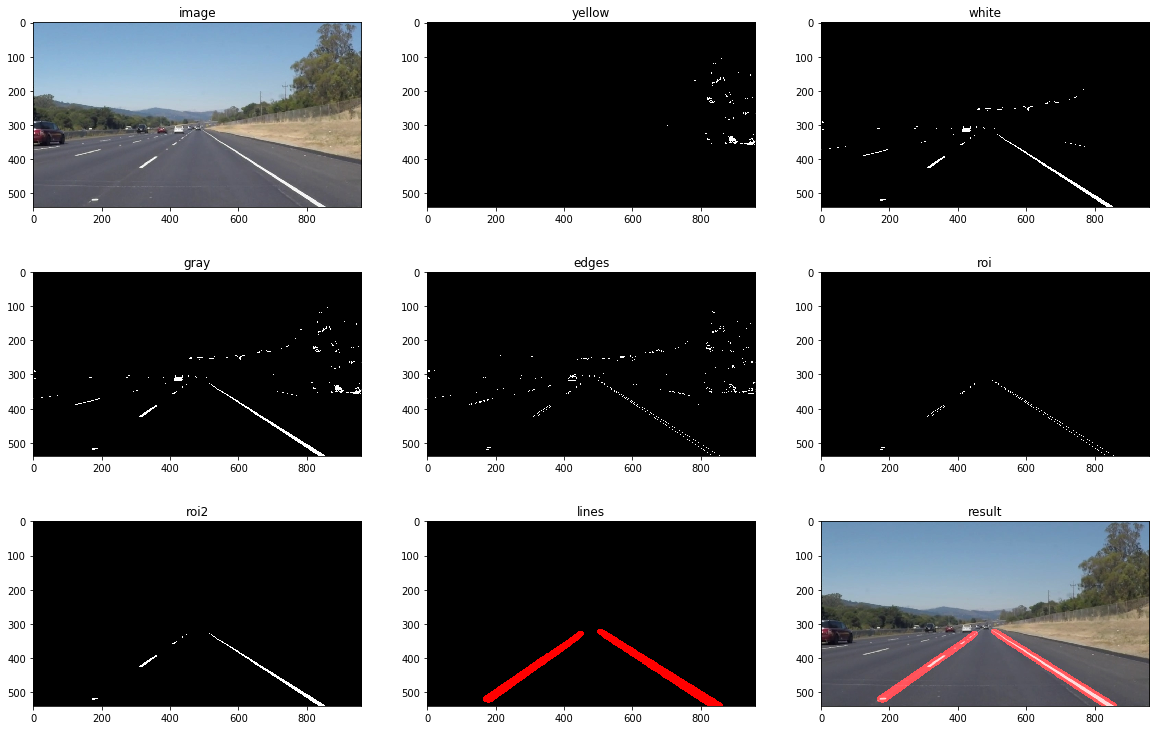

In [12]:
for test_image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + test_image)
    pipeline_process(img)